In [160]:
%load_ext autoreload
%autoreload 2
from common import *
from envs import *
from copy import deepcopy
from RiskAverseMCTS import RiskAverseMCTS
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
N_alpha = 4
N_params = 4
N_rollouts = 50
N_iter = 500
alpha_vals = np.linspace(0.25,1.0,N_alpha)
param_vals = np.arange(N_params)
mdps = [LavaGoalOneD(param=p) for p in param_vals]
rewards = np.zeros([N_alpha, N_params, N_rollouts])
belief = np.ones(N_params, dtype='float')/N_params

In [175]:
for i, alpha in enumerate(alpha_vals):
    for j, mdp in enumerate(mdps):
        agent = RiskAverseMCTS(mdp.state_space, mdp.action_space, 
                               mdps, belief, max_depth=12, 
                               alpha=alpha, max_r=2., n_iter=N_iter )
        env = Env(mdp, agent)
        stats = env.rollout(n_rollouts=N_rollouts, render=False)
        rewards[i,j,:] = stats.total_rewards
        print("\r a =",alpha,"\tmdp",j,"reward:", np.mean(stats.total_rewards), end='', flush='True')
    print("\r a =",alpha,"\tavg_r:",np.mean(rewards[i,:,:]), "\tvar_r:", np.var(np.mean(rewards[i,:,:], axis=1)), flush='True')

/Users/apoorva/Dropbox/Stanford/asl/290_2/risk-sensitive-mcts/RiskAverseMCTS.py:69: RuntimeWarning: invalid value encountered in true_divide
  self.belief = belief/np.sum(belief)


 a = 0.25 	avg_r: -0.236 	var_r: 0.023198
 a = 0.5 	avg_r: 0.0255 	var_r: 0.02651075
 a = 0.75 	avg_r: -0.0285 	var_r: 0.03711875
 a = 1.0 	avg_r: 0.061 	var_r: 0.203909


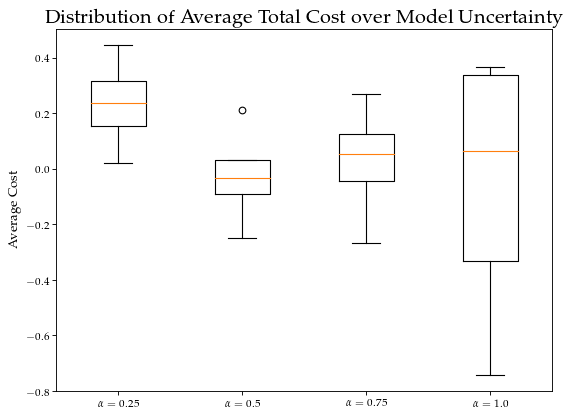

In [177]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.boxplot(np.mean(-rewards[:,:,:], axis=2).T, labels=[r"$\alpha=0.25$", r"$\alpha=0.5$", r"$\alpha=0.75$", r"$\alpha=1.0$"])
plt.title("Distribution of Average Total Cost over Model Uncertainty", fontsize=18)
plt.ylabel("Average Cost", fontsize=12)
#plt.xlabel("Avg Total Cost under Model", fontsize=16)
plt.legend(fontsize=16)
plt.savefig('performance_gridworld_spreads_5.pdf')
plt.show()

In [115]:
rewards_old[0,:,:] = rewards[0,:,:]

In [101]:
for i, alpha in enumerate(alpha_vals):
    print("\r a =",alpha,"\tavg_r:",np.mean(rewards[i,:,:]), "\tvar_r:", np.var(np.mean(rewards[i,:,:], axis=1)), flush='True')

 a = 0.5 	avg_r: 0.333333333333 	var_r: 0.00111111111111
 a = 0.666666666667 	avg_r: 0.416666666667 	var_r: 0.1225
 a = 0.833333333333 	avg_r: 0.5 	var_r: 0.25
 a = 1.0 	avg_r: 0.5 	var_r: 0.25


In [85]:
np.mean(-rewards[:,:,:], axis=2)

array([[-0.37333333, -0.08333333,  0.10666667, -0.26      ],
       [-0.50666667, -0.49333333, -0.41666667, -0.25666667],
       [-0.56333333, -0.05      , -0.46666667, -0.15666667]])

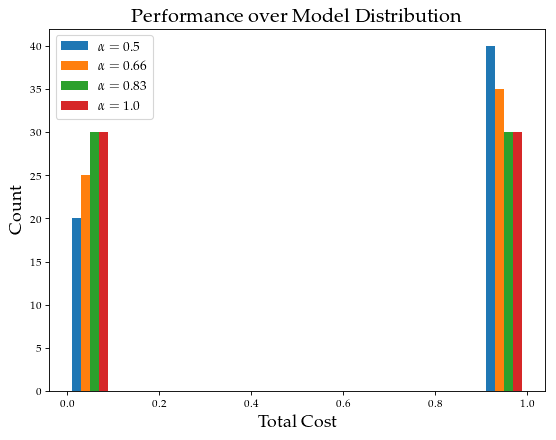

In [100]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(np.reshape(-rewards+1, [4, -1]).T, label=[r"$\alpha=0.5$", r"$\alpha=0.66$", r"$\alpha=0.83$", r"$\alpha=1.0$"])
plt.title("Performance over Model Distribution", fontsize=18)
plt.ylabel("Count", fontsize=16)
plt.xlabel("Total Cost", fontsize=16)
plt.legend(fontsize=12)
plt.savefig('performance_bandit.pdf')
plt.show()

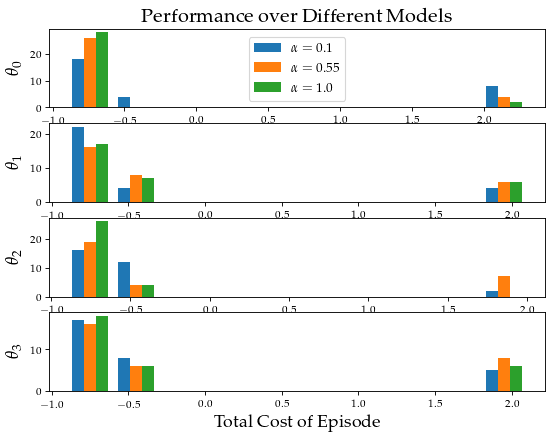

In [95]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(N_params):
    plt.subplot(N_params, 1, i+1)
    plt.hist(-old_rewards[:,i,:].T, label=[r"$\alpha=0.1$",r"$\alpha=0.55$", r"$\alpha=1.0$"])
    if i == 0:
        plt.title("Performance over Different Models", fontsize=18)
        plt.legend(fontsize=12)
    plt.ylabel(r"$\theta_"+str(i)+r"$", fontsize=16)
    if i == N_params - 1:
        plt.xlabel("Total Cost of Episode", fontsize=16)
plt.savefig('performance_per_model.pdf')
plt.show()

# Convergence plots

In [134]:
belief_curves = []
agent_value_curves = []
adv_value_curves = []
final_q_vals = []
final_n_vals = []
for i, alpha in enumerate(alpha_vals):
    agent = RiskAverseMCTS(mdps[0].state_space, mdps[0].action_space, 
                               mdps, belief, max_depth=5, 
                               alpha=alpha, max_r=1., n_iter=500 )
    s0 = mdps[0].reset()
    agent.MCTS(s0)
    belief_curves.append(deepcopy(agent.adv_dists))
    agent_value_curves.append(deepcopy(agent.agent_est_value))
    adv_value_curves.append(deepcopy(agent.adv_est_value))
    final_q_vals.append( [agent.Qha[(s0,a)] for a in mdps[0].action_space] )
    final_n_vals.append( [agent.Nha[(s0,a)] for a in mdps[0].action_space] )

In [136]:
1 - np.array(final_q_vals)

array([[ 0.80010604,  0.8174114 ,  0.84526316,  0.98729792],
       [ 0.81898455,  0.7681638 ,  0.76484848,  0.82688172],
       [ 0.79481132,  0.72213115,  0.72511848,  0.7027171 ],
       [ 0.78896104,  0.676957  ,  0.67888889,  0.61216395],
       [ 0.80487805,  0.68845316,  0.66237942,  0.56247316],
       [ 0.81167401,  0.66704805,  0.59955996,  0.49068861]])

In [135]:
np.array(final_n_vals)

array([[1886, 1298,  950,  866],
       [ 906, 1514, 1650,  930],
       [ 848, 1220, 1055, 1877],
       [ 924,  907,  900, 2269],
       [ 820,  918,  933, 2329],
       [ 908,  874,  909, 2309]])

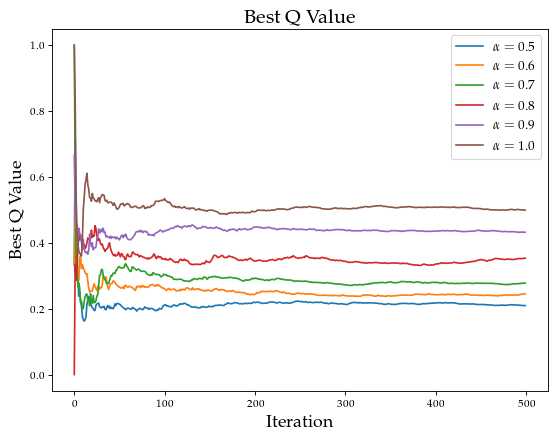

In [133]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i,a in enumerate(alpha_vals):
    plt.plot(np.array(agent_value_curves)[i], label=(r"$\alpha="+str(a)+r"$"))
plt.title("Best Q Value", fontsize=18)
plt.ylabel("Best Q Value", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()

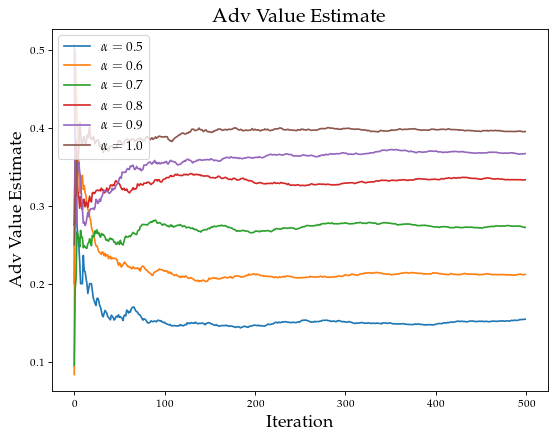

In [138]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i,a in enumerate(alpha_vals):
    plt.plot(np.array(adv_value_curves)[i], label=(r"$\alpha="+str(a)+r"$"))
plt.title("Adv Value Estimate", fontsize=18)
plt.ylabel("Adv Value Estimate", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [52]:
belief_curves = np.array(belief_curves)

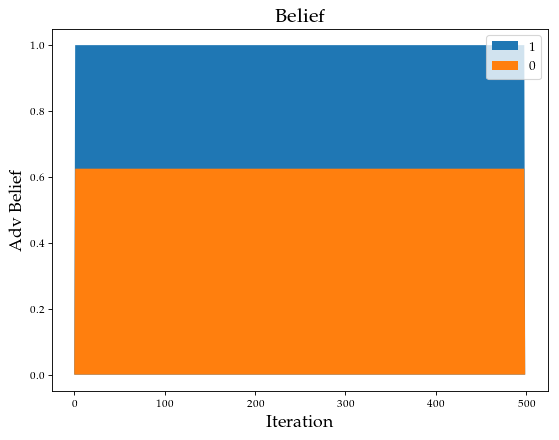

In [137]:
cum_belief_curves = np.cumsum(belief_curves, axis=2)
cum_belief_curves[:,0,:] = 0
cum_belief_curves[:,-1,:] = 0
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in reversed(range(N_params)):
    plt.fill(cum_belief_curves[3,:,i], label=str(i))
plt.title("Belief", fontsize=18)
plt.ylabel("Adv Belief", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [151]:
rewards = np.load('rewards_one.npy')

(3, 4, 30)